# Importando pacotes

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# Definindo máscara binária com base na cromaticidade, isolando o objeto vermelho acima do Husky

In [2]:
def binmask(frame):
    fb = cv2.GaussianBlur(frame,(7,7),0)
    fb = fb.astype(np.float32)
    b, g, r = cv2.split(fb)
    soma = b + g + r
    soma[soma==0] = 1
    g1 = g/soma
    r1 = r/soma
    b = (r1>0.45) & (g1<0.2)
    mask1 = (b * 255).astype(np.uint8)
    _, maskbin = cv2.threshold(mask1, 115, 255, cv2.THRESH_BINARY)
    return maskbin

# Corrigindo ruído por meio de Erosão e Dilatação 

In [3]:
def rruido(f):
    k7 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    k13 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31))
    aberta = cv2.morphologyEx(f, cv2.MORPH_OPEN, k7)
    fechada = cv2.morphologyEx(aberta, cv2.MORPH_CLOSE, k13)
    return fechada

# Apagando os contornos que não são o Husky

In [4]:
def contor(cc):
    contornos, _ = cv2.findContours(cc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    limpo = np.zeros_like(cc) 
    maxc = None
    if contornos:
        maxc = max(contornos, key=cv2.contourArea)
        if cv2.contourArea(maxc) > 1000: 
            cv2.drawContours(limpo, [maxc], -1, 255, thickness=cv2.FILLED)
    return limpo, maxc

# Achando o centróide do Husky

In [5]:
def centroide(xx):
    M = cv2.moments(xx)
    if M["m00"] > 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return (cX, cY)
    else:
        return None

# Conversão do plano xy para os valores do mundo real

In [6]:
def mundo(u_img, v_img):
    u = u_img * 2.0
    v = v_img * 2.0
    x_mm = (H_MM * (u - CX)) / FX
    y_mm = (H_MM * (CY - v)) / FY
    return x_mm / 1000.0, y_mm / 1000.0

# Formar elipse para achar orientação

In [7]:
def orient(frame, contorno, ponta_anterior):
    if contorno is None or len(contorno) < 5:
        return frame, ponta_anterior
    
    elipse = cv2.fitEllipse(contorno)
    (xc, yc), (d1, d2), angle = elipse
    cv2.ellipse(frame, elipse, (0, 255, 255), 2)
    rmajor = max(d1, d2) / 2
    if d1 > d2: angle = angle
    theta = np.deg2rad(angle)
    L = 60
    xt_A = int(xc + L * math.sin(theta))
    yt_A = int(yc - L * math.cos(theta))
    xt_B = int(xc - L * math.sin(theta))
    yt_B = int(yc + L * math.cos(theta))
    ponta_escolhida = (xt_A, yt_A)
    
    if ponta_anterior is not None:
        xp, yp = ponta_anterior
        dist_A = (xt_A - xp)**2 + (yt_A - yp)**2
        dist_B = (xt_B - xp)**2 + (yt_B - yp)**2
        if dist_B < dist_A:
            ponta_escolhida = (xt_B, yt_B)
    
    cv2.line(frame, (int(xc), int(yc)), ponta_escolhida, (0, 0, 255), 3)
    return frame, ponta_escolhida

# Plotar gráficos de trajetória e posição

In [8]:
def pltgraph(t, x_mundo, y_mundo, theta, u_img, v_img):

    plt.figure(figsize=(6, 6))
    plt.plot(x_mundo, y_mundo, 'b-', label='Robô')
    plt.scatter(x_mundo[0], y_mundo[0], color='green', label='Início')
    plt.scatter(x_mundo[-1], y_mundo[-1], color='red', label='Fim')
    plt.title("Trajetória Executada (Mundo)")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.axis('equal') 
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 8))
    
    plt.subplot(3, 1, 1)
    plt.plot(t, x_mundo)
    plt.ylabel("X (m)")
    plt.title("Evolução das Variáveis")
    plt.grid(True)
    
    plt.subplot(3, 1, 2)
    plt.plot(t, y_mundo)
    plt.ylabel("Y (m)")
    plt.grid(True)
    
    plt.subplot(3, 1, 3)
    plt.plot(t, theta) # Ângulo em radianos
    plt.ylabel("Orientação (rad)")
    plt.xlabel("Tempo (s)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(u_img, v_img, 'r-')
    plt.title("Trajetória no Plano da Imagem")
    plt.xlabel("u (pixels)")
    plt.ylabel("v (pixels)")
    plt.xlim(0, 1920) # Ajustado para sua resolução W
    plt.ylim(0, 1080) # Ajustado para sua resolução H
    plt.gca().invert_yaxis() 
    plt.grid(True)
    plt.show()

In [9]:
def gravar(nome_arquivo, largura, altura, fps):
    codec = cv2.VideoWriter_fourcc(*'mp4v')
    gravador = cv2.VideoWriter(nome_arquivo, codec, fps, (int(largura), int(altura)))
    return gravador

# Definindo dados da câmera

In [10]:
FX = 2216.537  
FY = 2184.502
CX = 1077.202
CY = 1952.590
H_MM = 2400.0  
W = 1920
H = 1080

# Função principal para ler o vídeo

In [11]:
def lervideo(arq):
    vid = cv2.VideoCapture(arq)
    
    fps_real = vid.get(cv2.CAP_PROP_FPS)
    if fps_real <= 0 or math.isnan(fps_real): 
        fps_real = 30.0 
    nomeb = arq.split('.')[0]
    nomeframe = f"{nomeb}_resultado.mp4"
    nomemask = f"{nomeb}_mascara.mp4"
    grav_frame = gravar(nomeframe, W, H, fps_real)
    grav_mask = gravar(nomemask, W, H, fps_real)
    
    ret, frame = vid.read()
    cv2.namedWindow('Video 1', cv2.WINDOW_NORMAL)
    cv2.namedWindow('Video Binario', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video 1', 800, 600)
    cv2.resizeWindow('Video Binario', 800, 600)

    ultima_ponta = None
    traj_x = []
    traj_y = []
    traj_theta = [] 
    traj_u = []     
    traj_v = []     
    traj_t = [] 

    while True:
        ret, framebase = vid.read()
        if not ret:
            break
        frame = cv2.resize(framebase, (W, H), interpolation=cv2.INTER_LINEAR)
        mv = binmask(frame)
        rr = rruido(mv)
        fi, contr = contor(rr) 
    
        if contr is not None:
            frame, ultima_ponta = orient(frame, contr, ultima_ponta)
            centro = centroide(contr)
            
            if centro is not None and ultima_ponta is not None:
                cx, cy = centro
                px, py = ultima_ponta 
                rx_m, ry_m = mundo(cx, cy)
                px_m, py_m = mundo(px, py)
                dy = py_m - ry_m
                dx = px_m - rx_m
                angulo_rad = math.atan2(dy, dx)
                angulo_graus = math.degrees(angulo_rad)
                traj_x.append(rx_m)
                traj_y.append(ry_m)
                traj_theta.append(angulo_rad)
                traj_u.append(cx)
                traj_v.append(cy)
                tempo_atual = vid.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
                traj_t.append(tempo_atual)
    
                cv2.circle(frame, centro, 8, (0, 255, 0), -1)
                
        fi_color = cv2.cvtColor(fi, cv2.COLOR_GRAY2BGR)
        fi_color = cv2.resize(fi_color, (W, H))
        if grav_frame is not None: grav_frame.write(frame)
        if grav_mask is not None: grav_mask.write(fi_color)
        cv2.imshow('Video 1', frame)
        cv2.imshow('Video Binario', fi)

        key = cv2.waitKey(33)
        if key == 27:
            break
    if grav_frame is not None: grav_frame.release()
    if grav_mask is not None: grav_mask.release()
    vid.release()
    cv2.destroyAllWindows()

    if len(traj_x) > 0:
        pltgraph(traj_t, traj_x, traj_y, traj_theta, traj_u, traj_v)
    else:
        print("Nenhum dado foi coletado.")
    return 

# Ativando a função para o vídeo 1

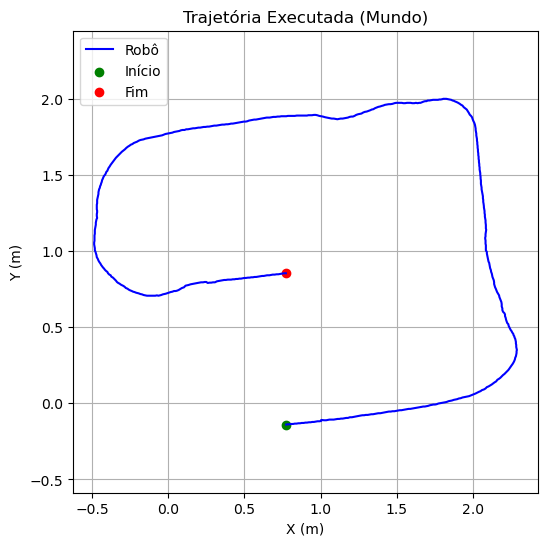

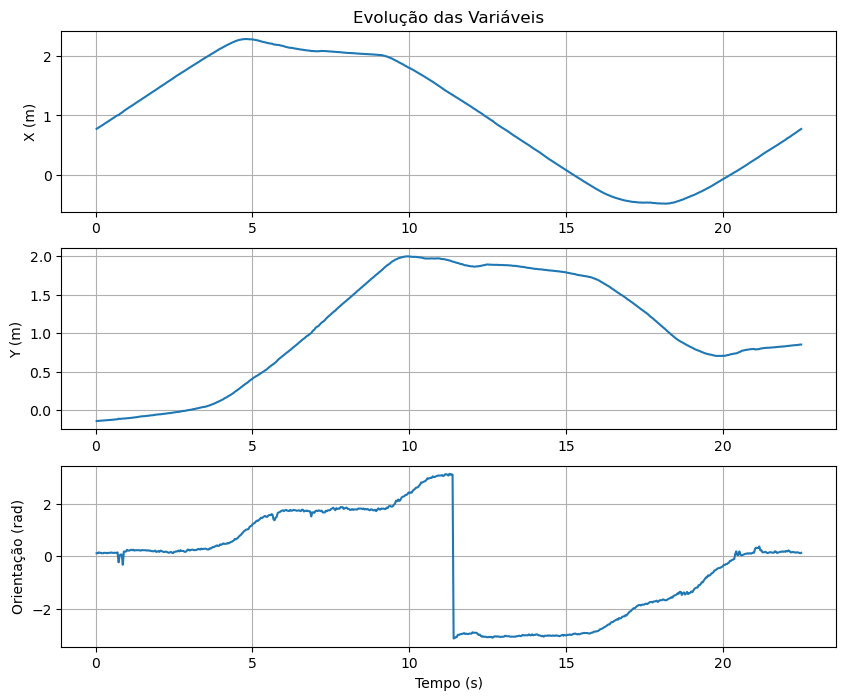

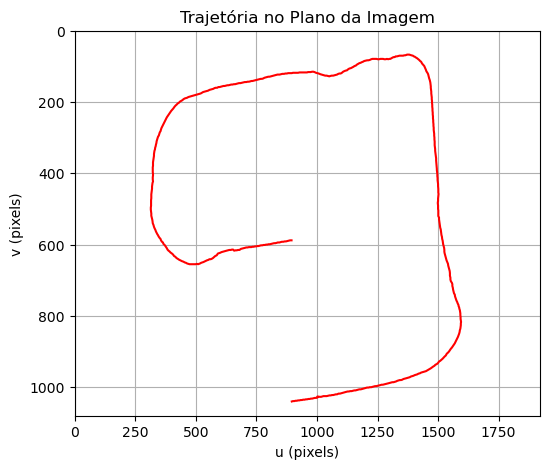

In [12]:
arquivo = 'video1.mp4'
v11 = lervideo(arquivo)

# Ativando a função para o vídeo 2

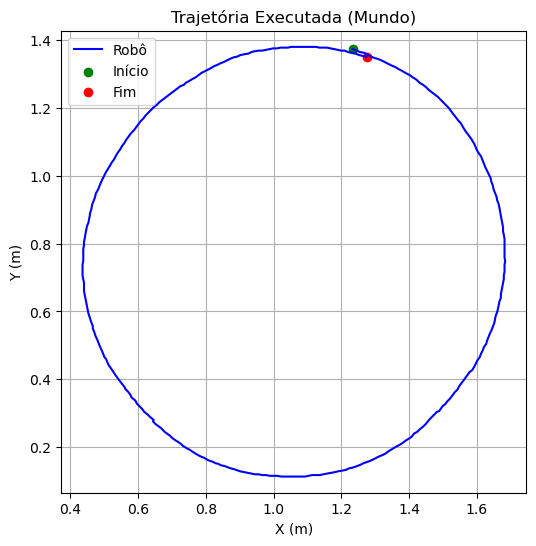

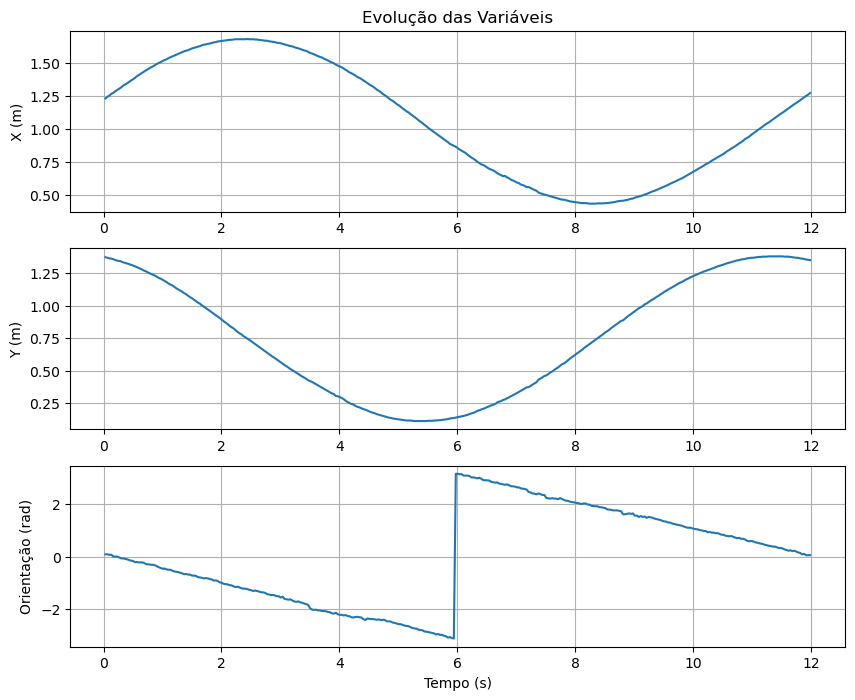

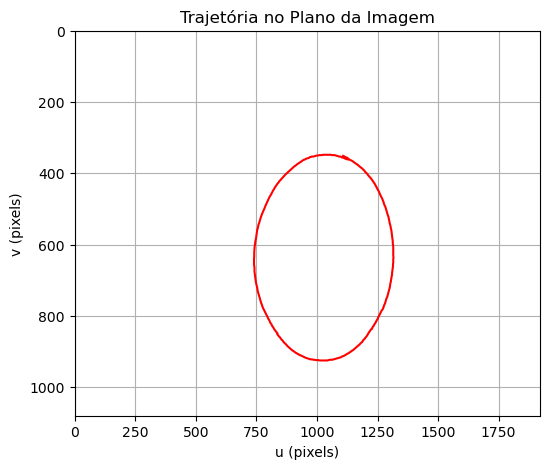

In [13]:
arq1 = 'video2.mp4'
v22 = lervideo(arq1)